## TEXT CLASSIFICATION
#### QUESTIONNAIRE CLASSIFICATION NOTEBOOK
##### USING RANDOM FOREST ALGORITHM TO CLASSIFY THE TEXT

In [1]:
import os
import re
import MeCab
import pickle
import gensim
import ast
import lda
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim import similarities 
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import spacy
from pprint import pprint
import warnings
import logging
from google.cloud import storage as gcs
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV, ShuffleSplit
from scipy.spatial.distance import pdist, squareform
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from collections import Counter
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
%matplotlib inline

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message


## IMPORTING DATASET
### THIS DATASET IS REFERED TO THE HAND-LABEL OVERALL SATISFACTION REASON FROM QUESTIONNAIRES

In [2]:
INPUT_BUCKET = 'gs://jesseulundo-bucket/questionnaire_classification/input_data/'
PROJECT_NAME = 'linkbal-dp'
BUCKET_NAME = 'mj-labeling-questionnaires-dev.datasets.linkbal.com' 
client = gcs.Client(PROJECT_NAME)
bucket = gcs.Bucket(client, name=BUCKET_NAME)
# JAPANESE STOPWORDS
jp_stop_words = pd.read_csv('gs://jesseulundo-bucket/questionnaire_classification/input_data/Japanese_stopword_list.txt', header=None, delimiter="\t")
# HAND LABELLED QUESTIONNAIRE DATA
qs = pd.read_csv(INPUT_BUCKET + 'ov_sat_cat_new_original.csv', sep=',')
qs 

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/

//anaconda3/en

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数（多い、少ない）
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容の質が低い
...,...,...,...,...
7005,121755,0,主催者が不在で進行してくれる人がいなく最終的にはグダグダになって終わった。あまりにも無責任す...,スタッフの対応が悪い
7006,121757,2,話す時間と移動の時間が短すぎて誰がどの人だか覚えていられなかった。,出会えなかった
7007,121758,2,肉バルと言いつつ、食事がサラダと肉1品のみ。もっと料理が出てくるような進行表でしたが、実際は...,飲食内容の質が低い
7008,121759,0,一人参加では不利過ぎます。,参加人数（多い、少ない）


## CATEGORIES LABELLING

In [3]:
category_codes = {'スタッフの対応が悪い': 0,
                  '参加人数（多い、少ない）': 1,
                  '出会えなかった': 2,
                  '飲食内容の質が低い': 3,
                  '会場や雰囲気が悪い': 4,
                  '参加条件が合ってない': 5,
                  '男女比があっていない': 6,
                  '掲載内容と相違がある': 7,
                  'その他': 8}

## DATA CLEANING AND PRE-PROCESSING

In [4]:
#qs = qs.drop(['want_recommend', 'want_recommend_reason'], axis=1)
qs = qs.dropna()
qs = qs.drop_duplicates() 
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数（多い、少ない）
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容の質が低い
...,...,...,...,...
7005,121755,0,主催者が不在で進行してくれる人がいなく最終的にはグダグダになって終わった。あまりにも無責任す...,スタッフの対応が悪い
7006,121757,2,話す時間と移動の時間が短すぎて誰がどの人だか覚えていられなかった。,出会えなかった
7007,121758,2,肉バルと言いつつ、食事がサラダと肉1品のみ。もっと料理が出てくるような進行表でしたが、実際は...,飲食内容の質が低い
7008,121759,0,一人参加では不利過ぎます。,参加人数（多い、少ない）


In [5]:
# REMOVING POSITIVE QUESTIONNAIRES AND MEANINGLESS COMMENTS
qs = qs[qs.overall_satisfaction < 3]
qs = qs[qs.overall_satisfaction_reason != '上記同様']
qs = qs[qs.overall_satisfaction_reason != '同上']
qs = qs[qs.overall_satisfaction_reason != '上記と同じ']
qs = qs[qs.overall_satisfaction_reason != '上記のとおり。']
qs = qs[qs.overall_satisfaction_reason != '上記記載']
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数（多い、少ない）
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容の質が低い
...,...,...,...,...
7005,121755,0,主催者が不在で進行してくれる人がいなく最終的にはグダグダになって終わった。あまりにも無責任す...,スタッフの対応が悪い
7006,121757,2,話す時間と移動の時間が短すぎて誰がどの人だか覚えていられなかった。,出会えなかった
7007,121758,2,肉バルと言いつつ、食事がサラダと肉1品のみ。もっと料理が出てくるような進行表でしたが、実際は...,飲食内容の質が低い
7008,121759,0,一人参加では不利過ぎます。,参加人数（多い、少ない）


### DATA DISTRIBUTION BY EACH CATEGORY

In [6]:
print(qs['categories'].value_counts())
qs_staff = qs[qs.categories == 'スタッフの対応が悪い']
qs_location = qs[qs.categories == '会場や雰囲気が悪い']
qs_age = qs[qs.categories == '参加条件が合ってない']
qs_num_att = qs[qs.categories == '参加人数（多い、少ない）']
qs_meet = qs[qs.categories == '出会えなかった']
qs_food_drink = qs[qs.categories == '飲食内容の質が低い']
qs_gender_ratio = qs[qs.categories == '男女比があっていない']
qs_content = qs[qs.categories == '掲載内容と相違がある']
qs_other = qs[qs.categories == 'その他']
print("CATEGORY DISTRIBUTION:")
print("NUMBER OF QUESTIONNAIRES ABOUT STAFF COMPLAINS: ", len(qs_staff))
print("NUMBER OF QUESTIONNAIRES ABOUT EVENT SPACE COMPLAINS: ", len(qs_location))
print("NUMBER OF QUESTIONNAIRES ABOUT PARTICIPANTS CONDITIONS NOT MET: ", len(qs_age))
print("NUMBER OF QUESTIONNAIRES ABOUT NUMBER OF PARTICIPANTS COMPLAINS: ", len(qs_num_att))
print("NUMBER OF QUESTIONNAIRES ABOUT NO Encounter COMPLAINS: ", len(qs_meet))
print("NUMBER OF QUESTIONNAIRES ABOUT FOOD AND DRINK COMPLAINS: ", len(qs_food_drink))
print("NUMBER OF QUESTIONNAIRES ABOUT GENDER RATIO NOT MET: ", len(qs_gender_ratio))
print("NUMBER OF QUESTIONNAIRES ABOUT DIFFERENCE ON THE CONTENT: ", len(qs_content))
print("NUMBER OF QUESTIONNAIRES ABOUT OTHER COMPLAINS: ", len(qs_other))


その他             1455
参加人数（多い、少ない）    1264
スタッフの対応が悪い      1006
男女比があっていない       609
出会えなかった          604
会場や雰囲気が悪い        562
飲食内容の質が低い        559
掲載内容と相違がある       341
参加条件が合ってない       255
Name: categories, dtype: int64
CATEGORY DISTRIBUTION:
NUMBER OF QUESTIONNAIRES ABOUT STAFF COMPLAINS:  1006
NUMBER OF QUESTIONNAIRES ABOUT EVENT SPACE COMPLAINS:  562
NUMBER OF QUESTIONNAIRES ABOUT PARTICIPANTS CONDITIONS NOT MET:  255
NUMBER OF QUESTIONNAIRES ABOUT NUMBER OF PARTICIPANTS COMPLAINS:  1264
NUMBER OF QUESTIONNAIRES ABOUT NO Encounter COMPLAINS:  604
NUMBER OF QUESTIONNAIRES ABOUT FOOD AND DRINK COMPLAINS:  559
NUMBER OF QUESTIONNAIRES ABOUT GENDER RATIO NOT MET:  609
NUMBER OF QUESTIONNAIRES ABOUT DIFFERENCE ON THE CONTENT:  341
NUMBER OF QUESTIONNAIRES ABOUT OTHER COMPLAINS:  1455


### TOKENIZING AND STEMMING

In [7]:
tagger = MeCab.Tagger()
def tokenize_stemmer(text):
    lemmas = []
    for line in tagger.parse(text).splitlines()[:-1]:
        surface, feature = line.split('\t')
        if feature.split(',')[6] != '*':
            lemmas.append(feature.split(',')[6])
    return lemmas

In [8]:
qs['tokenized_overall_satisfaction_reason'] = qs.apply(lambda row: tokenize_stemmer(row['overall_satisfaction_reason']), axis=1)
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, の, 対応, が, 悪い]"
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[他, の, の, お, 店, だ, と, 店員, や, 常連, さん, が, 気, を, ..."
2,111381,2,想像していた人数よりも少ない。,参加人数（多い、少ない）,"[想像, する, て, いる, た, 人数, より, も, 少ない, 。]"
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, だ, のに, マンツーマン, 、, フリー, タイム, が, 少ない, 。]"
4,111386,2,食べ物が酒の肴にならない,飲食内容の質が低い,"[食べ物, が, 酒, の, 肴, に, なる, ない]"
...,...,...,...,...,...
7005,121755,0,主催者が不在で進行してくれる人がいなく最終的にはグダグダになって終わった。あまりにも無責任す...,スタッフの対応が悪い,"[主催, 者, が, 不在, で, 進行, する, て, くれる, 人, が, いる, ない..."
7006,121757,2,話す時間と移動の時間が短すぎて誰がどの人だか覚えていられなかった。,出会えなかった,"[話す, 時間, と, 移動, の, 時間, が, 短い, すぎる, て, 誰, が, どの..."
7007,121758,2,肉バルと言いつつ、食事がサラダと肉1品のみ。もっと料理が出てくるような進行表でしたが、実際は...,飲食内容の質が低い,"[肉, バル, と, 言う, つつ, 、, 食事, が, サラダ, と, 肉, 品, のみ,..."
7008,121759,0,一人参加では不利過ぎます。,参加人数（多い、少ない）,"[一, 人, 参加, で, は, 不利, 過ぎる, ます, 。]"


### REMOVING STOPWORDS

In [9]:
stop = jp_stop_words.values.tolist()
stop = [item for sublist in stop for item in sublist]
qs['tokenized_overall_satisfaction_reason'] = qs['tokenized_overall_satisfaction_reason'].apply(lambda x: [item for item in x if item not in stop])
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, 対応, 悪い]"
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[店員, 常連, きかせる, 比べる, どうしても, 多い]"
2,111381,2,想像していた人数よりも少ない。,参加人数（多い、少ない）,"[想像, 人数, 少ない]"
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, マンツーマン, フリー, タイム, 少ない]"
4,111386,2,食べ物が酒の肴にならない,飲食内容の質が低い,"[食べ物, 酒, 肴]"
...,...,...,...,...,...
7005,121755,0,主催者が不在で進行してくれる人がいなく最終的にはグダグダになって終わった。あまりにも無責任す...,スタッフの対応が悪い,"[主催, 不在, 進行, 最終, 終わる, あまりに, 無責任, すぎ, まで, 街, コン..."
7006,121757,2,話す時間と移動の時間が短すぎて誰がどの人だか覚えていられなかった。,出会えなかった,"[話す, 移動, 短い, すぎる, どの人, 覚える]"
7007,121758,2,肉バルと言いつつ、食事がサラダと肉1品のみ。もっと料理が出てくるような進行表でしたが、実際は...,飲食内容の質が低い,"[肉, バル, 言う, つつ, 食事, サラダ, 肉, のみ, 料理, 出る, くる, 進行..."
7008,121759,0,一人参加では不利過ぎます。,参加人数（多い、少ない）,"[参加, 不利, 過ぎる]"


### LABEL LOADING

In [10]:
qs['category_code'] = qs['categories']
qs = qs.replace({'category_code':category_codes})

In [11]:
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason,category_code
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, 対応, 悪い]",0
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[店員, 常連, きかせる, 比べる, どうしても, 多い]",0
2,111381,2,想像していた人数よりも少ない。,参加人数（多い、少ない）,"[想像, 人数, 少ない]",1
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, マンツーマン, フリー, タイム, 少ない]",2
4,111386,2,食べ物が酒の肴にならない,飲食内容の質が低い,"[食べ物, 酒, 肴]",3
...,...,...,...,...,...,...
7005,121755,0,主催者が不在で進行してくれる人がいなく最終的にはグダグダになって終わった。あまりにも無責任す...,スタッフの対応が悪い,"[主催, 不在, 進行, 最終, 終わる, あまりに, 無責任, すぎ, まで, 街, コン...",0
7006,121757,2,話す時間と移動の時間が短すぎて誰がどの人だか覚えていられなかった。,出会えなかった,"[話す, 移動, 短い, すぎる, どの人, 覚える]",2
7007,121758,2,肉バルと言いつつ、食事がサラダと肉1品のみ。もっと料理が出てくるような進行表でしたが、実際は...,飲食内容の質が低い,"[肉, バル, 言う, つつ, 食事, サラダ, 肉, のみ, 料理, 出る, くる, 進行...",3
7008,121759,0,一人参加では不利過ぎます。,参加人数（多い、少ない）,"[参加, 不利, 過ぎる]",1


In [12]:
qs_new = qs[pd.notnull(qs['tokenized_overall_satisfaction_reason'])]
qs_new['tokenized_overall_satisfaction_reason'] = [' '.join(map(str, l)) for l in qs['tokenized_overall_satisfaction_reason']]
qs_new
print(qs_new['tokenized_overall_satisfaction_reason'])

0                                           店舗 スタッフ 対応 悪い
1                                 店員 常連 きかせる 比べる どうしても 多い
2                                               想像 人数 少ない
3                                 大 人数 マンツーマン フリー タイム 少ない
4                                                 食べ物 酒 肴
                              ...                        
7005            主催 不在 進行 最終 終わる あまりに 無責任 すぎ まで 街 コン 一番 最悪
7006                                 話す 移動 短い すぎる どの人 覚える
7007    肉 バル 言う つつ 食事 サラダ 肉 のみ 料理 出る くる 進行 表 実際 違う レディ...
7008                                            参加 不利 過ぎる
7009                         マイク 使う 団体 会場 うるさい すぎる しきる 意味
Name: tokenized_overall_satisfaction_reason, Length: 6655, dtype: object


## TRAIN AND TEST SPLIT

In [13]:
X_train, X_test, y_train, y_test = train_test_split(qs_new['tokenized_overall_satisfaction_reason'], 
                                                    qs['category_code'], 
                                                    test_size=0.10, 
                                                    random_state=8)

#### PARAMETERS SELECTION

In [14]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [15]:
X_train = X_train.values.tolist()
X_train

['女性 おかしい 人数 合わせる',
 '男女 比 明らか おかしい 参加 人数 そんなに 多い あまり 人気 会社 二度と 参加',
 '出会える 人数 少ない 組 ぐらい 参加 全員 会話 せる くださる 参加 人数 多い 全く 意味',
 '内容 一緒',
 'サクラ 投入 絶対 やめる',
 '楽しい',
 '人数 少ない',
 '男女 比',
 '対 会話 やり取り くださる 連絡 らい',
 '参加 人数 少ない',
 'という 鹿児島 店員 やる気 態度 悪い たいして お客 ドリンク 注文 客 カウンター まで 毎度 いく システム 勝手 話す 各自 替える 下さる 最初 初め 終わる 挨拶 だけ くる だけ 進行 \u3000 サイト 案内 書く 内容 違う 手抜き すごい 詐欺 まがい \u3000',
 '値段 割 食事 少ない',
 'とにかく ゆっくり 話せる トーク 低い 募集 ページ 進行 いきなり 少ない 思える',
 'ドリンク 追加 頼む いちいち サンダル いく 面倒くさい 注文 とり くる',
 'ペン 有料 悪質 食事 クッキー 飴 のみ 割り 合う',
 '男女 比 合う',
 '勧誘 目的 大量 交換 怖い',
 '喋る 会話',
 'スタッフ 段取り 悪い',
 '会場 狭い 料理 少ない イメージ 違う 無理 連絡 交換 作る カップ リンク 連絡 とる 登録 無駄',
 '主催 規約 違反 最後 詳しい 書く',
 '開催 場所 狭い テーブル 移動 難しい 椅子 持つ 移動 難儀 料理 最低 人数 告知',
 '２ 参加',
 '運営 円滑 行う スタッフ 必要',
 '想像 人数 少ない',
 '人数 少ない すぎる',
 '女の子 少ない すぎる',
 '値段 割 司会 進行 役目 少ない',
 '男女 比 やはり 多い',
 '開催 人数 料理 少ない 苦痛 参加 状況 途中 帰る',
 '満足 得る',
 '着地 予想 煽る 文面 きる 人数 無理 クローク 代 取る 定員 態度 悪い クローク 代 について 記載 人数 少ない スペース 余裕 まで クローク 代 取る 態度 違和感',
 '飲食 人数 少ない 料金 高い もったいない イメージ',
 'パーティー 婚 活 苦手 男性 動く 嫌 楽しめ

## TEXT REPRESENTATION

In [16]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(5989, 300)
(666, 300)


In [17]:
for category, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' CATEGORY:".format(category))
    print(" MOST CORRELATED UNIGRAMS:\n. {}".format('\n. '.join(unigrams[-5:])))
    print(" MOST CORRELATED BIGRAMS:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'その他' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. つまらない
. 理由
. 通り
. 人数
. 少ない
 MOST CORRELATED BIGRAMS:
. 少ない すぎる
. 人数 少ない

# 'スタッフの対応が悪い' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 対応
. 進行
. 司会
. 運営
. スタッフ
 MOST CORRELATED BIGRAMS:
. 人数 少ない
. スタッフ 対応

# '会場や雰囲気が悪い' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 雰囲気
. うるさい
. 場所
. 会場
. 狭い
 MOST CORRELATED BIGRAMS:
. 人数 少ない
. 会場 狭い

# '出会えなかった' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 話す
. 全員
. 交換
. 話せる
. 出会い
 MOST CORRELATED BIGRAMS:
. 人数 少ない
. 連絡 交換

# '参加人数（多い、少ない）' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 参加
. すぎる
. 中止
. 人数
. 少ない
 MOST CORRELATED BIGRAMS:
. 少ない すぎる
. 人数 少ない

# '参加条件が合ってない' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 男性
. 確認
. 限定
. 条件
. 年齢
 MOST CORRELATED BIGRAMS:
. イベント 参加
. 男性 参加

# '掲載内容と相違がある' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 書く
. 突破
. 違う
. 詐欺
. 実際
 MOST CORRELATED BIGRAMS:
. 少ない すぎる
. 人数 少ない

# '男女比があっていない' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. おかしい
. 男性
. 女性
. 比率
. 男女
 MOST CORRELATED BIGRAMS:
. 女性 少ない
. 男女 比率

# '飲食内容の質が低い' CAT

## SAVING THE FILES

In [18]:
# X_train
with open('/Users/jesse.ulundo/demo_tests/rf/X_train_RF.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('/Users/jesse.ulundo/demo_tests/rf/X_test_RF.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('/Users/jesse.ulundo/demo_tests/rf/y_train_RF.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('/Users/jesse.ulundo/demo_tests/rf/y_test_RF.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('/Users/jesse.ulundo/demo_tests/rf/df_qs_RF.pickle', 'wb') as output:
    pickle.dump(qs, output)
    
# features_train
with open('/Users/jesse.ulundo/demo_tests/rf/features_train_RF.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('/Users/jesse.ulundo/demo_tests/rf/labels_train_RF.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('/Users/jesse.ulundo/demo_tests/rf/features_test_RF.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('/Users/jesse.ulundo/demo_tests/rf/labels_test_RF.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('/Users/jesse.ulundo/demo_tests/rf/tfidf_RF.pickle', 'wb') as output:
    pickle.dump(tfidf, output)

In [19]:
#!gsutil -m cp *.pickle gs://jesseulundo-bucket/questionnaire_classification/train_and_test_data/

## MODEL TRAINING

In [20]:
# Dataframe
path_df_qs = "/Users/jesse.ulundo/demo_tests/rf/df_qs_RF.pickle"
with open(path_df_qs, 'rb') as data:
    df_qs = pickle.load(data)

# features_train
path_features_train = "/Users/jesse.ulundo/demo_tests/rf/features_train_RF.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "/Users/jesse.ulundo/demo_tests/rf/labels_train_RF.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "/Users/jesse.ulundo/demo_tests/rf/features_test_RF.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "/Users/jesse.ulundo/demo_tests/rf/labels_test_RF.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [21]:
df_qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason,category_code
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, 対応, 悪い]",0
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[店員, 常連, きかせる, 比べる, どうしても, 多い]",0
2,111381,2,想像していた人数よりも少ない。,参加人数（多い、少ない）,"[想像, 人数, 少ない]",1
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, マンツーマン, フリー, タイム, 少ない]",2
4,111386,2,食べ物が酒の肴にならない,飲食内容の質が低い,"[食べ物, 酒, 肴]",3
...,...,...,...,...,...,...
7005,121755,0,主催者が不在で進行してくれる人がいなく最終的にはグダグダになって終わった。あまりにも無責任す...,スタッフの対応が悪い,"[主催, 不在, 進行, 最終, 終わる, あまりに, 無責任, すぎ, まで, 街, コン...",0
7006,121757,2,話す時間と移動の時間が短すぎて誰がどの人だか覚えていられなかった。,出会えなかった,"[話す, 移動, 短い, すぎる, どの人, 覚える]",2
7007,121758,2,肉バルと言いつつ、食事がサラダと肉1品のみ。もっと料理が出てくるような進行表でしたが、実際は...,飲食内容の質が低い,"[肉, バル, 言う, つつ, 食事, サラダ, 肉, のみ, 料理, 出る, くる, 進行...",3
7008,121759,0,一人参加では不利過ぎます。,参加人数（多い、少ない）,"[参加, 不利, 過ぎる]",1


### CROSSVALIDATING FOR HYPERPARAMETER TUNING USING RANDOM FOREST

In [22]:
rf_0 = RandomForestClassifier(random_state = 8)
rf_0

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

### RANDOMIZE SEARCH CROSS VALIDATION

In [23]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 6)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, num = 6)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 36, 52, 68, 84, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 360, 520, 680, 840, 1000]}


### PERFORMING RANDOM SEARCH

In [24]:
rfc = RandomForestClassifier(random_state=8)
random_search = RandomizedSearchCV(estimator = rfc,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   scoring = 'accuracy',
                                   cv = 3,
                                   verbose = 2, 
                                   random_state = 8)

random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   4.5s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   4.3s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   4.3s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   4.5s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   4.3s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimator

[CV]  n_estimators=680, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=True, total=   2.5s
[CV] n_estimators=520, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=36, bootstrap=False 
[CV]  n_estimators=520, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=36, bootstrap=False, total=   4.3s
[CV] n_estimators=520, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=36, bootstrap=False 
[CV]  n_estimators=520, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=36, bootstrap=False, total=   4.1s
[CV] n_estimators=520, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=36, bootstrap=False 
[CV]  n_estimators=520, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=36, bootstrap=False, total=   4.1s
[CV] n_estimators=840, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=36, bootstrap=False 
[CV]  n_estimators=840, min

[CV]  n_estimators=360, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=36, bootstrap=False, total=   5.1s
[CV] n_estimators=360, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=36, bootstrap=False 
[CV]  n_estimators=360, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=36, bootstrap=False, total=   5.0s
[CV] n_estimators=360, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=36, bootstrap=False 
[CV]  n_estimators=360, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=36, bootstrap=False, total=   4.9s
[CV] n_estimators=680, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=36, bootstrap=True 
[CV]  n_estimators=680, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=36, bootstrap=True, total=   3.9s
[CV] n_estimators=680, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=36, bootstrap=True 
[CV]  n_estimators=680, min_

[CV]  n_estimators=840, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   4.5s
[CV] n_estimators=840, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=840, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total=   4.6s
[CV] n_estimators=840, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=840, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, total=   3.7s
[CV] n_estimators=840, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=840, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False, total=   3.6s
[CV] n_estimators=840, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=840, m

[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=84, bootstrap=False, total=   4.4s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=False 
[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=False, total=   4.1s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=False 
[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=False, total=   4.1s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=False 
[CV]  n_estimators=680, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=False, total=   4.1s
[CV] n_estimators=680, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=68, bootstrap=False 
[CV]  n_estimators=680, min_

[CV]  n_estimators=520, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.8s
[CV] n_estimators=520, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=520, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.8s
[CV] n_estimators=520, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=520, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.8s
[CV] n_estimators=360, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=True 
[CV]  n_estimators=360, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=True, total=   1.9s
[CV] n_estimators=360, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=True 
[CV]  n_estimators=360,

[CV]  n_estimators=680, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=84, bootstrap=True, total=   7.8s
[CV] n_estimators=680, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=84, bootstrap=True 
[CV]  n_estimators=680, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=84, bootstrap=True, total=   8.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=52, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=52, bootstrap=True, total=   2.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=52, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=52, bootstrap=True, total=   1.9s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=52, bootstrap=True 
[CV]  n_estimators=200, min_sam

[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=  12.4s
[CV] n_estimators=520, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False 
[CV]  n_estimators=520, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False, total=   3.6s
[CV] n_estimators=520, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False 
[CV]  n_estimators=520, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False, total=   3.3s
[CV] n_estimators=520, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False 
[CV]  n_estimators=520, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False, total=   3.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=200, mi

[CV]  n_estimators=360, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   1.9s
[CV] n_estimators=360, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=360, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   1.8s
[CV] n_estimators=360, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=360, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   1.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False, total=   1.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=68, bootstrap=False 
[CV]  n_estimators=200, m

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 26.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [25]:
print("THE BEST HYPERPARAMETERS FROM RANDOM SEARCH ARE:")
print(random_search.best_params_)
print("")
print("THE MEAN ACCURACY OF A MODEL WITH THESE HYPERPARAMETERS IS:")
print(random_search.best_score_)

THE BEST HYPERPARAMETERS FROM RANDOM SEARCH ARE:
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 84, 'bootstrap': True}

THE MEAN ACCURACY OF A MODEL WITH THESE HYPERPARAMETERS IS:
0.6139584292939074


### Grid Search Cross Validation

In [26]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, 
                           param_grid = param_grid,
                           scoring ='accuracy',
                           cv = cv_sets,
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  9.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sampl...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=8,
                                  

In [27]:
print("THE BEST HYPERPARAMETERS FROM GRID SEARCH ARE:")
print(grid_search.best_params_)
print("")
print("THE MEAN ACCURACY OF A MODEL WITH THESE HYPERPARAMETERS IS:")
print(grid_search.best_score_)

THE BEST HYPERPARAMETERS FROM GRID SEARCH ARE:
{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 800}

THE MEAN ACCURACY OF A MODEL WITH THESE HYPERPARAMETERS IS:
0.6100151745068284


In [28]:
best_rfc = random_search.best_estimator_

In [29]:
best_rfc

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=84, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

## MODEL FIT AND PERFORMANCE

In [30]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=84, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [31]:
rfc_pred = best_rfc.predict(features_test)

#### Training accuracy

In [32]:
# Training accuracy
print("THE TRAINING ACCURACY IS: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

THE TRAINING ACCURACY IS: 
0.776757388545667


#### TESTING ACCURACY

In [33]:
# Test accuracy
print("THE TEST ACCURACY IS: ")
print(accuracy_score(labels_test, rfc_pred))

THE TEST ACCURACY IS: 
0.6081081081081081


## RESULTS

In [34]:
print("CLASSIFICATION REPORT")
print(classification_report(labels_test,rfc_pred))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.55      0.64      0.59       105
           1       0.69      0.77      0.73       129
           2       0.57      0.46      0.51        56
           3       0.62      0.54      0.58        56
           4       0.53      0.32      0.40        63
           5       0.85      0.50      0.63        22
           6       0.53      0.65      0.59        49
           7       0.50      0.11      0.18        28
           8       0.61      0.74      0.67       158

    accuracy                           0.61       666
   macro avg       0.61      0.52      0.54       666
weighted avg       0.60      0.61      0.59       666



//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12473 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12479 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12483 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12501 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12398 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 23550 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/b

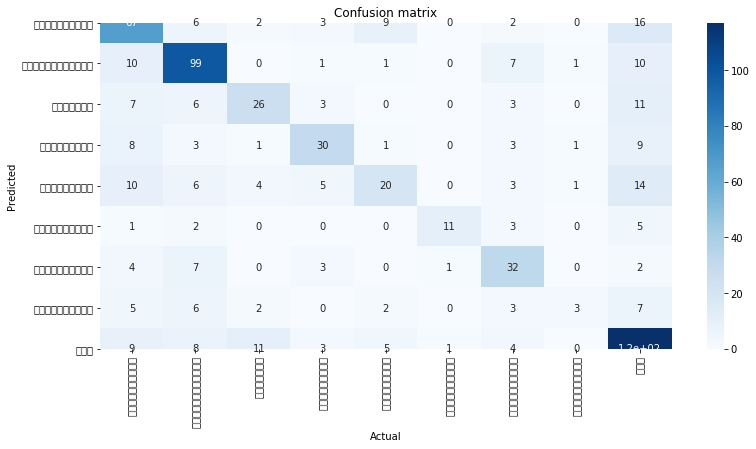

In [35]:
aux_df = df_qs[['categories', 'category_code']].drop_duplicates().sort_values('category_code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['categories'].values, 
            yticklabels=aux_df['categories'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [36]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.5900900900900901

In [37]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.6081081081081081

In [38]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.776757,0.608108


In [39]:
## Saving the models to gcp bucket [currently saving in local directory]

In [40]:
#with open('/Users/jesse.ulundo/demo_tests/Models/best_rfc.pickle', 'wb') as output:
    #pickle.dump(best_rfc, output)
    
#with open('/Users/jesse.ulundo/demo_tests/Models/df_models_rfc.pickle', 'wb') as output:
    #pickle.dump(df_models_rfc, output)

In [41]:
## perform classification on untrained data

In [42]:
## LOADING UNTRAINED DATA 

In [43]:
#qs_new['predicted_category'] = model.predict(qs_new['tokenized_overall_satisfaction_reason'])

In [44]:
#qs_new

In [45]:
#qs_age = qs[qs.categories == '参加者の年齢']
#qs_age